<a href="https://colab.research.google.com/github/iaintheardofu/Data-Science-Projects-and-perspectives/blob/main/IS6733Lab3_Mike_Pendleton_ijd706_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

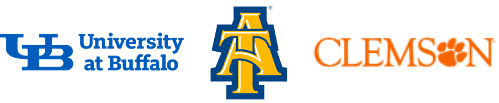

# Lab 3: Cyberbullying Detection Using BERT

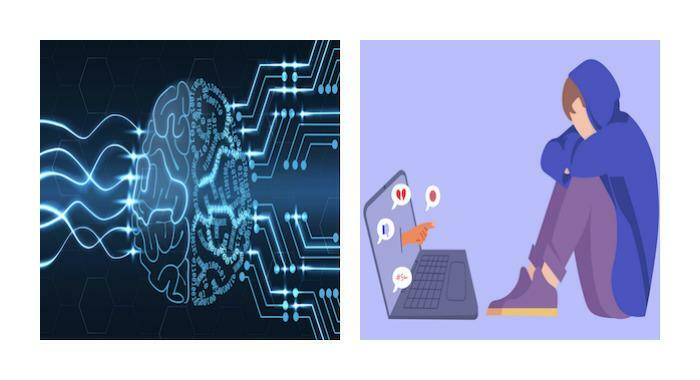

In this lab, we will learn how AI can be developed to detect cyberbullying. We will use a publicly available dataset of cyberbullying texts, and train an AI model on this dataset to automatically detect cyberbullying text. You will learn:

1. AI development process
2. Train and test your own AI for cyberbullying detection
3. Run AI on your own samples
4. Hypterpaprameter tuning to improve model performance

First, we need to download softwares used in the lab. Just hit the 'play' button run the code below.

### Preliminaries

In [1]:
# change the output font size
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 20px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [2]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
!git clone https://github.com/nishantvishwamitra/CyberbullyingLab1.git

fatal: destination path 'CyberbullyingLab1' already exists and is not an empty directory.


Next, we install transformers which offer us some tools we can use

In [4]:
!pip install transformers

Let's import all our softwares dependencies in our iPython notebook

In [5]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from transformers import AdamW

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [6]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data Preprocessing

While training AI, datasets are divided into three parts: training dataset, validation dataset and test dataset.
- Training set: feed the AI, so the AI can keep learning cyberbullying and non-cyberbullying knowledge.
- Validation set:  can help us and the AI know whether its predictions are getting better or worse.
- Test set: is to evaluate the AI’s performance.

They are different datasets, should have no overlap among them.
Let's create these three parts for our dataset.

In [7]:
# Dowload the cyberbullying speech dataset
# Let's dowload the main dataset frist
main_df = pd.read_csv('CyberbullyingLab1/formspring_dataset.csv', sep = '\t')

# Let's see how many smaples we have
print('Total number of samples:', main_df.shape)
main_df = main_df.sample(n = main_df.shape[0])
main_df = main_df[['text', 'label']]

# Let's take a look at a few samples from our dataset
print(main_df.head())

Total number of samples: (13159, 2)
                                                    text  label
11206     Q: have you kissed my bro isaac<br>A: haha no.      0
3713   Q: @y3 @l!X $3D yUh wUz j3rk!n oFf t@ q@y p0RN...      0
757    Q: Best thing that happened to you this summer...      0
11558  Q: your parents tell you that you need to chan...      0
6479   Q: Will...will you marry me?<br>A: Haa  uhm I'...      0


Note:
* 0 indicates non-cyberbullying
* 1 indicates cyberbullying

While training AI, datasets are divided into three parts: training dataset, testing dataset and validation dataset. Let's create these three parts for our dataset.

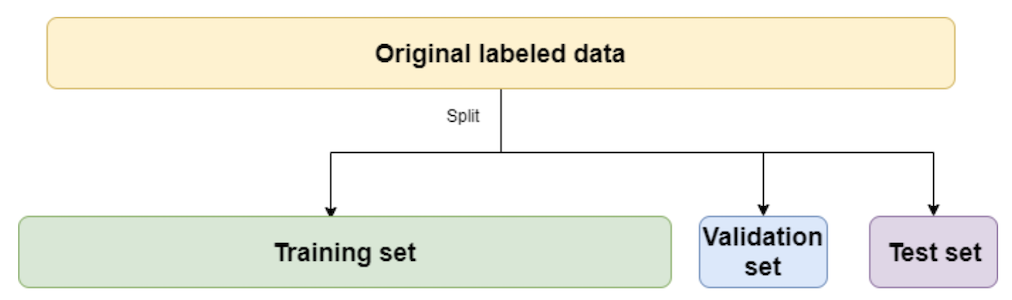

In [8]:
# let's divide the dataset into non-cyberbullying and cyberbullying samples
o_class = main_df.loc[main_df.label == 0, :]
l_class = main_df.loc[main_df.label == 1, :]

# let's create train, val and test splits
train_val = main_df.iloc[:int(main_df.shape[0] * .80)]
test_df = main_df.iloc[int(main_df.shape[0] * .80):]
train_df = train_val.iloc[:int(train_val.shape[0] * .80)]
val_df = train_val.iloc[int(train_val.shape[0] * .80):]

#print(train.shape, val.shape, test.shape)
print('\nTraining set:\n', train_df.label.value_counts())
print('\nValidation set:\n', val_df.label.value_counts())
print('\nTest set:\n', test_df.label.value_counts())


Training set:
 label
0    7868
1     553
Name: count, dtype: int64

Validation set:
 label
0    1963
1     143
Name: count, dtype: int64

Test set:
 label
0    2460
1     172
Name: count, dtype: int64


The first step in natural language processing for AI is tokenization. In this process, we split the text into 'tokens', that are then given unique numbers that are understood by a machine. Take a look at the example below.

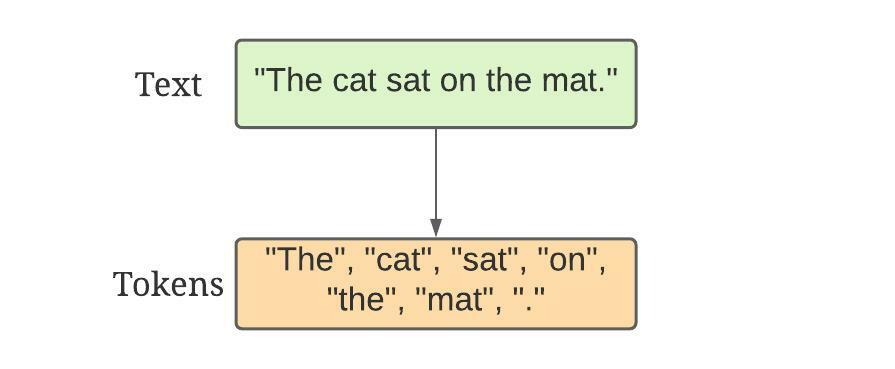

In [9]:
# Let's use a tokenizer. This is the first step in NLP
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
#  Let's see how the tokenizer works
sentences = "the cat sat on the mat"

tokens = tokenizer.tokenize(sentences)
for token in tokens:
    print(token)

the
cat
sat
on
the
mat


- - - -
**<font color='red'>Task 1:</font>
Add code below to preprocess the following cyberbullying text, and include the generated tokens in your report.**<br>
“Harlem shake is just an excuse to go full retard for 30 seconds”.
- - - -

In [11]:
# TODO: Enter your code here
# Data Preprocessing

from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Sample cyberbullying text to tokenize
text_to_preprocess = "Harlem shake is just an excuse to go full retard for 30 seconds."

# Tokenize the text
inputs = tokenizer.encode_plus(
    text_to_preprocess,
    add_special_tokens=True,
    max_length=128,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt',
)

# Extract tokens and their IDs
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
token_ids = inputs['input_ids'][0].tolist()

# Print the tokens and their corresponding IDs
print("Tokens:", tokens)
print("Token IDs:", token_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokens: ['[CLS]', 'harlem', 'shake', 'is', 'just', 'an', 'excuse', 'to', 'go', 'full', 're', '##tar', '##d', 'for', '30', 'seconds', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

With tokenizer, now we can prepare the input data that the AI model needs

In [12]:
# Prepare the dataset
class CyberbullyingDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text = df.text.to_list()
        self.label = df.label.to_list()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text, # Sentence to encode.
            None, # Add another sequence to the inputs. 'None' means no other sequence is added.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            max_length = self.max_len, # Pad & truncate all sentences.
            pad_to_max_length = True, # Pad all samples to the same length.
            truncation = True, # Truncate all samples to the same length.
            return_token_type_ids = False,
            return_tensors = 'pt' # Return pytorch tensors.
        )
        label = torch.tensor(self.label[index], dtype = torch.long)

        return {
            'text': text,
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'label': label
        }

# The number of unique words in the vocabulary and the number of labels
VOCAB_SIZE = tokenizer.vocab_size
NUM_LABELS = train_df.label.nunique()
print("The number of unique words in the vocabulary:", VOCAB_SIZE)
print("The number of labels:", NUM_LABELS)

The number of unique words in the vocabulary: 30522
The number of labels: 2


In order to make the model understand both cyberbullying and non-cyberbullying data, we typically balance the datasets.

In [13]:
# Build a balanced dataset
def balence_data(dataframe):
    o_class = dataframe.loc[dataframe.label == 0, :]
    l_class = dataframe.loc[dataframe.label == 1, :]
    o_class = o_class.sample(n = l_class.shape[0])
    dataframe = pd.concat([o_class, l_class], axis = 0)
    dataframe = dataframe.sample(n = dataframe.shape[0])
    return dataframe

train_df = balence_data(train_df)
val_df = balence_data(val_df)
test_df = balence_data(test_df)

print('\nTraining set:\n', train_df.label.value_counts())
print('\nValidation set:\n', val_df.label.value_counts())
print('\nTest set:\n', test_df.label.value_counts())


Training set:
 label
1    553
0    553
Name: count, dtype: int64

Validation set:
 label
0    143
1    143
Name: count, dtype: int64

Test set:
 label
0    172
1    172
Name: count, dtype: int64


We need iterators to step through our dataset.

In [14]:
# Normally, we prepare the dataset with batches, it can help us to train the model faster.
MAX_LEN = 120
BATCH_SIZE = 32

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CyberbullyingDataset(df, tokenizer, max_len)
    return DataLoader(ds, batch_size = batch_size)

# Create the dataloaders
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

print("After we build the dataloaders, we can see the number of batches in each dataloader. It means we can train the model with {} samples in each time.".format(BATCH_SIZE))
print("The number of batches in the training dataloader:", len(train_data_loader))
print("The number of batches in the validation dataloader:", len(val_data_loader))
print("The number of batches in the test dataloader:", len(test_data_loader))

After we build the dataloaders, we can see the number of batches in each dataloader. It means we can train the model with 32 samples in each time.
The number of batches in the training dataloader: 35
The number of batches in the validation dataloader: 9
The number of batches in the test dataloader: 11


### AI Model Definition

Let's define some hyperparameters for our AI model, you can change them to adjust the performance of the model.

In [15]:
# Lets define some hyperparameters
N_EPOCHS = 5 # The number of epochs
LEARNING_RATE = 2e-5 # The learning rate
Num_classes = 2 # The number of classes

Let's instantiate our AI model.

In [16]:
# Download the tokenizer and model
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
bert_model = bert_model.to(device)

In [17]:
# Define the model
class CyberbullyingDetecter(nn.Module):
    def __init__(self, bert_model, Num_classes):
            super(CyberbullyingDetecter, self).__init__()
            self.bert = bert_model
            self.drop = nn.Dropout(p=0.3)
            self.out = nn.Linear(self.bert.config.hidden_size, Num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
        )['pooler_output']
        output = self.drop(pooled_output)
        return self.out(output)

# Create the model
model = CyberbullyingDetecter(bert_model, Num_classes)
model = model.to(device)

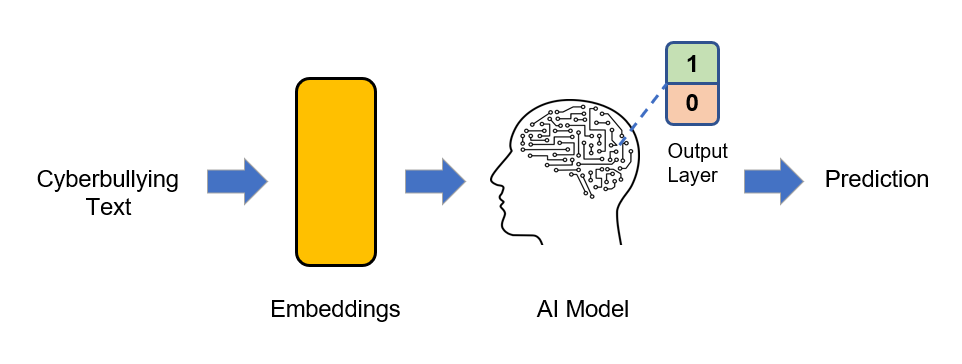

Now, let's define and the loss function.

In [18]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)

Define some functions for model training

In [19]:
# Let's define the training and testing procedures for our AI model
# Lets define our training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for d in tqdm(data_loader):
    inputs_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['label'].to(device)
    # print(inputs_ids.shape, attention_mask.shape, label.shape)
    outputs = model(inputs_ids, attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels)
    acc = accuracy(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define our testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
      for d in data_loader:
        inputs_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        outputs = model(inputs_ids, attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# define a function for evaluation
def predict_cb(sentence):
    sentence = str(sentence)
    sentence = ' '.join(sentence.split())
    inputs = tokenizer.encode_plus(
        sentence, # Sentence to encode.
        None, # Add another sequence to the inputs. 'None' means no other sequence is added.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN, # Pad & truncate all sentences.
        pad_to_max_length = True, # Pad all samples to the same length.
        truncation = True, # Truncate all samples to the same length.
        return_token_type_ids = True # Return token_type_ids
    )
    output = model(torch.tensor(inputs['input_ids']).unsqueeze(0).to(device), torch.tensor(inputs['attention_mask']).unsqueeze(0).to(device))
    # print(output)
    preds, ind= torch.max(F.softmax(output, dim=-1), 1)
    if ind.item() == 1:
        return preds, ind, 'Cyberbullying detected.'
    else:
        return preds, ind, 'Cyberbullying not detected.'

Next, Let's begin training our AI model

### Training Process

In [20]:
# Let's train our model
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_data_loader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.526 | Train Acc: 72.90% | Val. Loss: 0.357 | Val. Acc: 85.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.261 | Train Acc: 89.93% | Val. Loss: 0.336 | Val. Acc: 87.34% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.136 | Train Acc: 95.31% | Val. Loss: 0.564 | Val. Acc: 83.54% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.078 | Train Acc: 97.59% | Val. Loss: 0.522 | Val. Acc: 85.60% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.056 | Train Acc: 97.95% | Val. Loss: 0.633 | Val. Acc: 84.24% |


- - - -
**<font color='red'>Task 2:</font>
After training, what is the training accuracy that your model achieves?**<br>
- - - -

In [21]:
#TODO: add your code below to print the final training accuracy out
# Assuming train function and necessary variables are already defined

# Train the model
train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)

# Print the final training accuracy
print(f'Final Training Accuracy: {train_acc*100:.2f}%')

  0%|          | 0/35 [00:00<?, ?it/s]

Final Training Accuracy: 99.38%


### Model Evaluation

- - - -
**<font color='red'>Task 3:</font>
Let's review the previous code then finish the next code cell**<br>
- - - -

In [22]:
#TODO: complete the code below
# Assuming evaluate function and necessary variables are already defined

# Evaluate the model on the test data loader
test_loss, test_acc = evaluate(model, test_data_loader, criterion)

# Print the test loss and accuracy
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

| Test Loss: 0.639 | Test Acc: 85.23% |


### Deployment

We can use the prediction function predict_cb to predict whether a sentence is cyberbullying or not.


In [23]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Assuming you want to load a pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define the prediction function
def predict_cb(sentence, model, tokenizer):
    model.eval()  # Put the model in evaluation mode
    with torch.no_grad():  # Disable gradient calculation to save memory and computation
        inputs = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            return_tensors='pt',  # Return PyTorch tensors
            max_length=128,
            padding='max_length',
            truncation=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        confidence, predicted_class = torch.max(probabilities, dim=1)
    return confidence, predicted_class

# Example 1: "Hello World!"
text = 'hello world!'
ret = predict_cb(text, model, tokenizer)  # Provide `model` and `tokenizer` as arguments
print("Sample prediction: ", ret[1].item(), f'Confidence: {ret[0].item() * 100:.2f}%')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sample prediction:  0 Confidence: 67.91%


- - - -
**<font color='red'>Task 4:</font>
Use the samples in [this file](https://raw.githubusercontent.com/cuadvancelab/materials/main/lab1/samples.txt) and your model to detect the cyberbullying samples**<br>
- - - -

In [24]:
# You have already defined or loaded the `model` and `tokenizer` as before

text_samples = [
    "you guys are a bunch of losers, fuck you",
    "I'm never going to see your little pathetic self again",
    "She looks really nice today!"
]

# Define the prediction function
def predict_cb(sentence, model, tokenizer):
    model.eval()  # Put the model in evaluation mode
    with torch.no_grad():  # Disable gradient calculation to save memory and computation
        inputs = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            return_tensors='pt',  # Return PyTorch tensors
            max_length=128,
            padding='max_length',
            truncation=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        confidence, predicted_class = torch.max(probabilities, dim=1)
    return confidence, predicted_class

# Prediction for text 1
text1 = text_samples[0]
ret1 = predict_cb(text1, model, tokenizer)
print(f"Text 1: '{text1}'")
print("Predicted class:", ret1[1].item(), f'Confidence: {ret1[0].item() * 100:.2f}%')
print("=========================================")

# Prediction for text 2
text2 = text_samples[1]
ret2 = predict_cb(text2, model, tokenizer)
print(f"Text 2: '{text2}'")
print("Predicted class:", ret2[1].item(), f'Confidence: {ret2[0].item() * 100:.2f}%')
print("=========================================")

# Prediction for text 3
text3 = text_samples[2]
ret3 = predict_cb(text3, model, tokenizer)
print(f"Text 3: '{text3}'")
print("Predicted class:", ret3[1].item(), f'Confidence: {ret3[0].item() * 100:.2f}%')

Text 1: 'you guys are a bunch of losers, fuck you'
Predicted class: 0 Confidence: 67.66%
Text 2: 'I'm never going to see your little pathetic self again'
Predicted class: 0 Confidence: 70.70%
Text 3: 'She looks really nice today!'
Predicted class: 0 Confidence: 69.16%


In [25]:
def predict_cb(sentence, model, tokenizer):
    model.eval()  # Put the model in evaluation mode
    with torch.no_grad():  # Disable gradient calculation to save memory and computation
        inputs = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            return_tensors='pt',  # Return PyTorch tensors
            max_length=128,
            padding='max_length',
            truncation=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        confidence, predicted_class = torch.max(probabilities, dim=1)
        return confidence, predicted_class

# Assuming you have a list of labels somewhere in your code
label_names = ['Not Cyberbullying', 'Cyberbullying']

In [26]:
My_Sentence = 'your mom is like a snowblower' #@param {type:"string"}

ret = predict_cb(My_Sentence, model, tokenizer)
print("===========The Model Prediction is===========")
if ret:
    print("Predicted class:", ret[1].item(), f'Confidence: {ret[0].item() * 100:.2f}%')
else:
    print("No prediction available.")


===========The Model Prediction is===========
Predicted class: 0 Confidence: 66.14%


## Hyperparameter Tuning

In [27]:
# @title A fast training function
def train_model(model, train_data_loader, val_data_loader, number_of_epochs, learning_rate, verbose=True):
    """
    Trains our AI model and plots the learning curve
    Arguments:
        model: model to be trained
        train_iterator: an iterator over the training set
        validation_iterator: an iterator over the validation set
        number_of_epochs: The number of times to go through our entire dataset
        optimizer: the optimization function, defaults to None
        criterion: the loss function, defaults to None
        learning_rate: the learning rate, defaults to 0.001
        verbose: Boolean - whether to print accuracy and loss
    Returns:
        learning_curve: Dictionary - contains variables for plotting the learning curve
    """

    # initialize variables for plotting
    epochs = [i for i in range(number_of_epochs)]
    train_losses = []
    validation_losses = []
    validation_accs = []

    # define the optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
    criterion = nn.CrossEntropyLoss().to(device)

    model = model.to(device)

    # train the model
    for epoch in range(number_of_epochs):
        train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_data_loader, criterion)
        train_losses.append(train_loss)
        validation_losses.append(valid_loss)
        validation_accs.append(valid_acc)
        if verbose:
            print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

    test_loss, test_acc = evaluate(model, test_data_loader, criterion)
    if verbose:
        print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')
    print()

    epochs = np.asarray(epochs)
    train_losses = np.asarray(train_losses)
    validation_losses = np.asarray(validation_losses)
    validation_accs = np.asarray(validation_accs)

    learning_curve = {
        'epochs': epochs,
        'train_losses': train_losses,
        'validation_losses': validation_losses,
        'validation_accs': validation_accs,
        'learning_rate': learning_rate,
    }

    return learning_curve

- - - -
**<font color='red'>Task 5:</font> Compare different traning epochs with 2, 10. You can try more different settings and find a suitable epoch number.**
- - - -


In [28]:
training_epochs = [2, 10]
learning_curve = {}

for i, epoch in enumerate(training_epochs,1):
    print(f'Training for {epoch} epochs')
    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
    model = CyberbullyingDetecter(bert_model, Num_classes).to(device)
    # Train the model
    learning_curve[i] = train_model(model, train_data_loader, val_data_loader, epoch, 2e-5, verbose=True)
    print('training complete!')


Training for 2 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.527 | Train Acc: 72.56% | Val. Loss: 0.420 | Val. Acc: 83.52% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.280 | Train Acc: 89.13% | Val. Loss: 0.357 | Val. Acc: 86.30% |
Test Loss: 0.363 | Test Acc: 87.41% |

training complete!
Training for 10 epochs


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.586 | Train Acc: 66.56% | Val. Loss: 0.359 | Val. Acc: 84.19% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.321 | Train Acc: 88.41% | Val. Loss: 0.426 | Val. Acc: 84.58% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.139 | Train Acc: 95.20% | Val. Loss: 0.530 | Val. Acc: 84.91% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.099 | Train Acc: 97.05% | Val. Loss: 0.629 | Val. Acc: 83.87% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.082 | Train Acc: 97.05% | Val. Loss: 0.602 | Val. Acc: 83.52% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.036 | Train Acc: 98.75% | Val. Loss: 0.625 | Val. Acc: 85.28% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.014 | Train Acc: 99.64% | Val. Loss: 0.717 | Val. Acc: 84.61% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.004 | Train Acc: 99.82% | Val. Loss: 0.790 | Val. Acc: 85.97% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 0.001 | Train Acc: 100.00% | Val. Loss: 0.841 | Val. Acc: 85.97% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 0.001 | Train Acc: 100.00% | Val. Loss: 0.880 | Val. Acc: 86.32% |
Test Loss: 0.833 | Test Acc: 86.08% |

training complete!


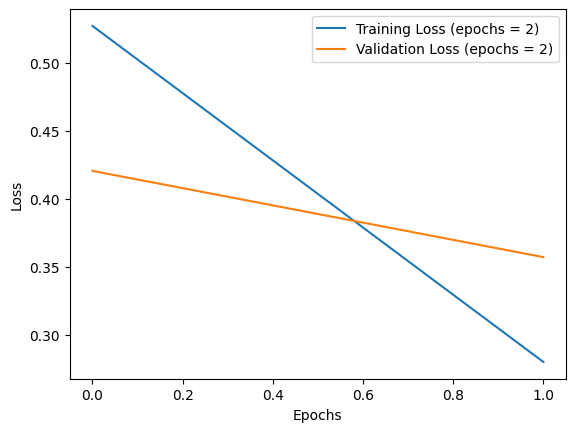

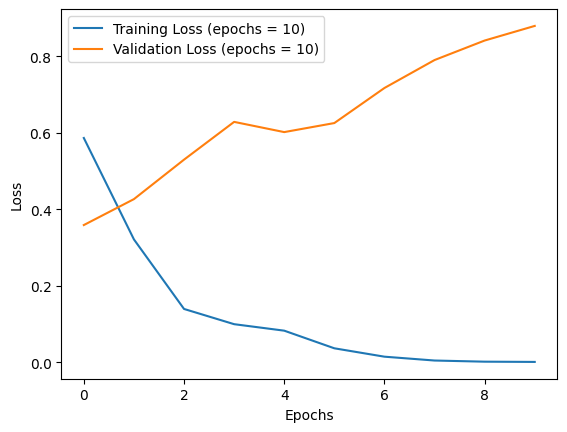

In [29]:
for i, epoch in enumerate(training_epochs,1):
    plt.plot(learning_curve[i]['epochs'], learning_curve[i]['train_losses'], label=f'Training Loss (epochs = {epoch})')
    plt.plot(learning_curve[i]['epochs'], learning_curve[i]['validation_losses'], label=f'Validation Loss (epochs = {epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

- - - -
**<font color='red'>Task 6:</font> Compare different learning rates with 0.1, 1e-3 and 1e-5. You can try with your own settings and find the best learning rate.**
- - - -
Learning rate needs to be chosen carefully in order for gradient descent to work properply. How quickly we update the parameters of our models is determined by the learning rate. If we choose the learning rate to be too small, we may need a lot more iteration to converge to the optimal values. If we choose the learning rate to be too big, we may go past our optimal values. So, it is important to choose the learning rate carefully.


In [30]:
learning_rates = [0.01, 1e-3, 1e-5]
learning_curve = {}

for i, lr in enumerate(learning_rates,1):
    print('Learning rate:', lr)
    # Initialize the model
    bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
    model = CyberbullyingDetecter(bert_model, Num_classes).to(device)
    # Train the model
    learning_curve[i] = train_model(model, train_data_loader, val_data_loader, 5, lr, verbose=True)
    print('Training complete!')

Learning rate: 0.01


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 4.478 | Train Acc: 48.14% | Val. Loss: 0.855 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 2.763 | Train Acc: 49.61% | Val. Loss: 2.586 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 2.309 | Train Acc: 50.23% | Val. Loss: 0.779 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 2.612 | Train Acc: 50.20% | Val. Loss: 5.544 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 2.893 | Train Acc: 51.65% | Val. Loss: 0.709 | Val. Acc: 50.00% |
Test Loss: 0.709 | Test Acc: 49.81% |

Training complete!
Learning rate: 0.001


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.003 | Train Acc: 50.80% | Val. Loss: 0.775 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.793 | Train Acc: 52.30% | Val. Loss: 0.919 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.843 | Train Acc: 48.90% | Val. Loss: 0.707 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.764 | Train Acc: 50.87% | Val. Loss: 0.693 | Val. Acc: 50.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.754 | Train Acc: 49.93% | Val. Loss: 0.695 | Val. Acc: 50.00% |
Test Loss: 0.695 | Test Acc: 49.81% |

Training complete!
Learning rate: 1e-05


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.551 | Train Acc: 70.15% | Val. Loss: 0.337 | Val. Acc: 85.95% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.275 | Train Acc: 90.11% | Val. Loss: 0.350 | Val. Acc: 86.00% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.119 | Train Acc: 96.52% | Val. Loss: 0.441 | Val. Acc: 86.32% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.093 | Train Acc: 96.79% | Val. Loss: 0.378 | Val. Acc: 87.73% |


  0%|          | 0/35 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.047 | Train Acc: 98.48% | Val. Loss: 0.525 | Val. Acc: 85.63% |
Test Loss: 0.497 | Test Acc: 88.54% |

Training complete!


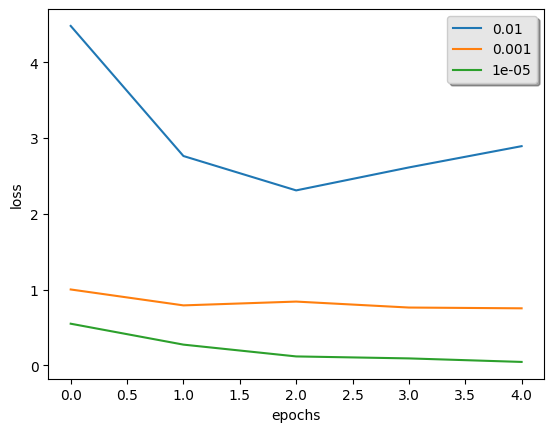

In [31]:
for i, lr in enumerate(learning_rates,1):
    plt.plot(learning_curve[i]["epochs"], np.squeeze(learning_curve[i]["train_losses"]), label=learning_curve[i]["learning_rate"])

plt.ylabel('loss')
plt.xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

- - - -
**<font color='red'>Task 7:</font> Discussion**
- - - -
We experimented with different hyperparameters in this lab, what can you conclude about training AI models? Specifically, what are your observations about the model before Vs. after hyperparameter tuning?

#Importance of Hyperparameter Tuning: Hyperparameter tuning is essential for optimizing the model's performance. The default parameters are not necessarily the best for all types of data and tasks.

#Training Epochs: Before tuning, a model might not have seen the data enough times to learn effectively, resulting in underfitting. After tuning, by increasing the number of epochs, the model might learn more details and nuances, possibly improving accuracy. However, too many epochs can lead to overfitting, where the model learns the training data too well, including noise.

#Learning Rates: Before tuning, a learning rate that's too high can cause the model to converge too quickly to a suboptimal solution, or even diverge. A learning rate that's too low can slow down training or cause the model to get stuck in a local minimum.  After tuning, finding an optimal learning rate can significantly speed up training and help the model reach the global minimum.

#Effect on Generalization: Before tuning, the model may not generalize well to new data, meaning its predictions on unseen data might be poor. After tuning, if the hyperparameters are chosen wisely, the model should generalize better, maintaining performance on both the training data and unseen test data.

#Trade-offs: There's often a trade-off between training time and model accuracy. More epochs or a smaller learning rate might improve accuracy but also increase training time. Similarly, there's a trade-off between bias and variance. Hyperparameter tuning seeks to find a balance where the model has low bias (good performance on the training set) and low variance (good performance on the test set).

#Model Robustness: Before tuning, the model might be more sensitive to variations in the data. After tuning, the model could become more robust, effectively handling a variety of data inputs.

#Observational Learning: The process of hyperparameter tuning itself is an educational experience. It provides insights into the model's learning process and how different parameters affect learning dynamics. Tracking performance changes through validation loss and accuracy gives practical feedback on model behavior changes due to hyperparameter adjustments.

#In summary, hyperparameter tuning is a powerful step in the AI development process that can significantly affect the final model's performance. It involves a lot of experimentation, and each choice of hyperparameters needs to be validated against a held-out set to ensure that the model is learning generalizable patterns. The optimal set of hyperparameters is often task-specific, and finding them can be considered an art as much as it is a science.